# Peer-to-peer lending: Predicting credit default

In this project we are going to use a public dataset of [LendingClub.com](https://www.lendingclub.com/). <br>
LendingClub is a company that connect people who needs money (borrowers) with people who wants to borrow money (investors). This business model is called "Peer-to-peer lending".<br><br>
The main idea of this notebook is using a <b>Decision Tree and Random Forest</b> machine learning algorithms to predict if the borrower will pay the loan in full or not.


### Dataset description:

<b>credit.policy:</b> 1 if the customer meets LendingClub.com's credit underwriting criteria and 0 otherwise.<br>
<b>purpose:</b> Loan purpose.<br>
<b>int.rate:</b> Loan interest rate (eg: 10% equals 0.10).<br>
<b>installment:</b> monthly installments of the loan.<br>
<b>log.annual.inc:</b> the natural log of the borrower's annual income.<br>
<b>dti:</b> loan amount divided by borrower's annual income.<br>
<b>fico:</b> borrower credit score.<br>
<b>days.with.cr.line:</b> number of days the borrower had a credit line.<br>
<b>revol.bal:</b> borrower's revolving balance.<br>
<b>revol.util:</b> rate of use of the borrower's rotating line.<br>
<b>inq.last.6mths:</b> number of borrower inquiries by creditors in the last 6 months.<br>
<b>delinq.2yrs:</b> the number of times the borrower had been more than 30 days overdue on a payment in the past 2 years.<br>
<b>pub.rec:</b> number of negative public records of the borrower.<br>
<b>not.fully.paid:</b> 1 if customer not fully payed the loan and 0 otherwise.

### Importing libraries:

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("dark")

### Importing data:

In [56]:
df_loans = pd.read_csv('loan_data.csv')
df_loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [57]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


### Exploratory Data Analysis:

First of all, we will understand the data we have and try to gather some insights about them.<br><br>
<b>Let's plot a FICO score distribution compared to the adherence to the LendingClub credit policy:

Text(0.5, 0, 'FICO')

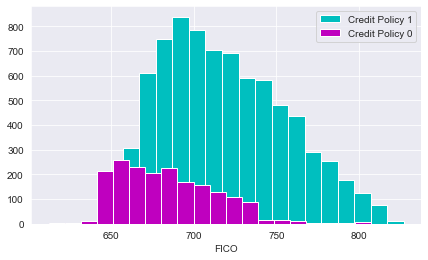

In [61]:
plt.figure(figsize=(7,4))
df_loans[df_loans['credit.policy']==1]['fico'].hist(bins=20, color='c', label='Credit Policy 1')
df_loans[df_loans['credit.policy']==0]['fico'].hist(bins=20, color='m', label='Credit Policy 0')
plt.legend()
plt.xlabel('FICO')

Looking to this distribution, we can conclude that <b>people who meets LendingClub credit policy have a higher FICO score.</b> Probably the both ways of credit analysis have some correlation.

<b>Let's plot a FICO score distribution compared to the loan default:

Text(0.5, 0, 'FICO')

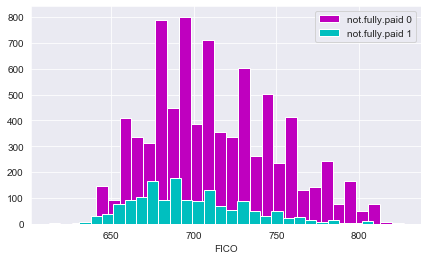

In [88]:
plt.figure(figsize=(7,4))
df_loans[df_loans['not.fully.paid']==0]['fico'].hist(bins=30, color='m', label='not.fully.paid 0')
df_loans[df_loans['not.fully.paid']==1]['fico'].hist(bins=30, color='c', label='not.fully.paid 1')
plt.legend()
plt.xlabel('FICO')

Right here, is possible to realize that <b>FICO score is not a strong variable to determine if borrower will pay the lending.</b> There should be other features to determine credit default.

<b>Now let's see the loan count by purpose (classified by not.fully.paid) in our dataset:

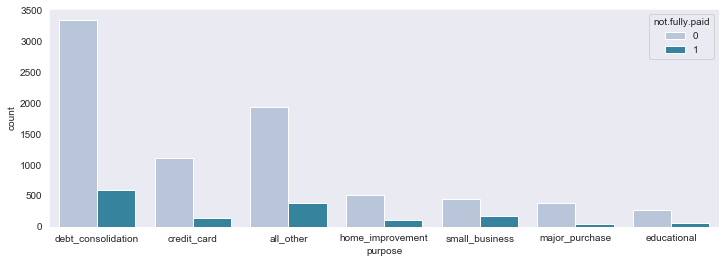

In [101]:
plt.figure(figsize=(12,4))
sns.countplot(x='purpose', hue='not.fully.paid',data=df_loans, palette='PuBuGn')

<b>The main loan purpose is "debt consolidation"</b> followed by "all other" and "credit card". Only with this plot, we cannot say with certainty that exists a "purpose" with more default than others.

<b>Let's look at the trend between FICO score and interest rate:</b>

<Figure size 504x288 with 0 Axes>

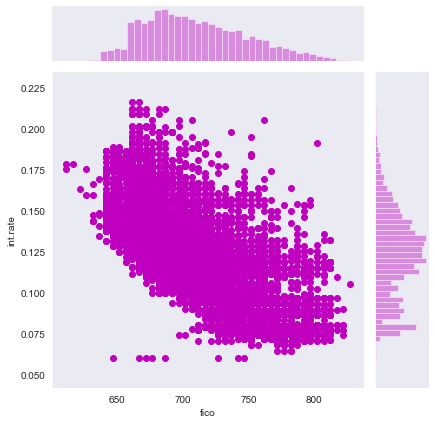

In [97]:
plt.figure(figsize=(7,4))
sns.jointplot(x='fico', y='int.rate', data=df_loans, color='m')

In this plot, is clear that the <b>interest rate has an inversely proportional relationship with FICO score.</b>

<b>Now, let's see if this trend changes with credit.policy and not.fully.paid:</b>

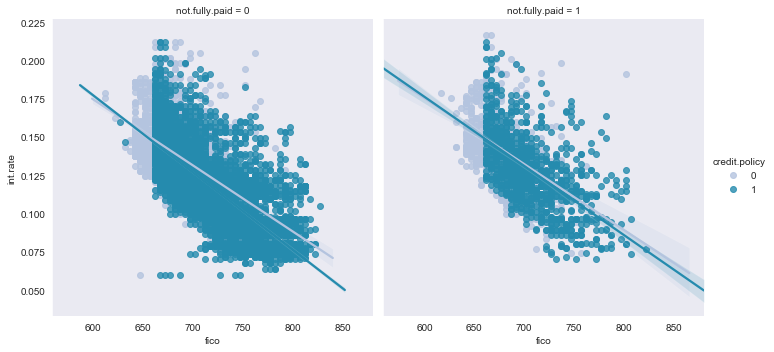

In [106]:
sns.lmplot(x='fico', y='int.rate', data=df_loans, hue='credit.policy', col='not.fully.paid',palette='PuBuGn' )

The relationship between interest rate and FICO score does not change.

### Data Cleaning:

#### Categorical data
First of all, in our data cleaning, we need to transform the column "Purpose" in <i>dummies variables</i>, so that SkLearn can read and interpret these variables in our machine learning model

In [112]:
features_list = ['purpose']
cleaned_df = pd.get_dummies(df_loans, columns=features_list, drop_first=True)
cleaned_df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [113]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
credit.policy                 9578 non-null int64
int.rate                      9578 non-null float64
installment                   9578 non-null float64
log.annual.inc                9578 non-null float64
dti                           9578 non-null float64
fico                          9578 non-null int64
days.with.cr.line             9578 non-null float64
revol.bal                     9578 non-null int64
revol.util                    9578 non-null float64
inq.last.6mths                9578 non-null int64
delinq.2yrs                   9578 non-null int64
pub.rec                       9578 non-null int64
not.fully.paid                9578 non-null int64
purpose_credit_card           9578 non-null uint8
purpose_debt_consolidation    9578 non-null uint8
purpose_educational           9578 non-null uint8
purpose_home_improvement      9578 non-null uint8
purpose_major_purchase        9

### Train / Test Split:

In [111]:
from sklearn.model_selection import train_test_split

X = cleaned_df.drop('not.fully.paid', axis=1)
y = cleaned_df['not.fully.paid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Training a Decision Tree Model:

In [114]:
from sklearn.tree import DecisionTreeClassifier

In [115]:
#Creating an instance for Decision Tree Classifier
dtree = DecisionTreeClassifier()

#Fit with train data
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Decision Tree Evaluation:

In [116]:
prediction = dtree.predict(X_test)

<b>Classification Report</b>

In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2403
           1       0.24      0.28      0.26       471

    accuracy                           0.74      2874
   macro avg       0.55      0.55      0.55      2874
weighted avg       0.75      0.74      0.74      2874



Looking <b>only at the weighted avg recall metric</b>, our model got the right answer in 74% of the cases. However, the model was very accurate predicting people who paid their debts (83% of accuracy) than predicting people who not paid their debts (28% of accuracy).<br>
It was expected, because in this data distribution we have more people who paid their debts than people who did not pay.

#### Confusion Matrix

In [123]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction))

[[1987  416]
 [ 340  131]]


When we look to the <b>True Positives</b> at the confusion matrix, it's plain to see that the model is better predicting people who paid their loans.

### Random Forest Model

Random forests consist of multiple single trees each based on a random sample of the training data. They are typically more accurate than single decision trees. Let's try to improve our model using a Random Forest to predict credit default.


In [125]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
#Creating an instance for Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=400)

#Fit with train data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Random Forest Evaluation:

In [141]:
prediction = rfc.predict(X_test)

#### Classification Report

In [142]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2403
           1       0.55      0.03      0.05       471

    accuracy                           0.84      2874
   macro avg       0.69      0.51      0.48      2874
weighted avg       0.79      0.84      0.77      2874



#### Confusion Matrix

In [132]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction))

[[2389   14]
 [ 457   14]]


### Conclusion:
Using Random Forest instead of Decision Tree <b>is not the best decision</b> in this particular case. <br>
The weighted avg precision of the model improve by 0.04 and the weighted avg recall improve by 0.10, but when we look to isolated variables, we see that recall in "True not.fully.paid" deteriorate by 0.25.<br>
This is terrible for our case, because, for a credit default prediction, "False Negatives" are very important.

